# ArtCap Color Palette ControlNet Dataset Generation

**Purpose:** Generate a high-quality dataset for training a ControlNet model using color palettes as conditioning images.  
**Dataset:** ArtCap (art images + captions)  
**Condition:** 5-color equal-width horizontal stripes extracted via K-Means

This notebook:
- Extracts dominant 5 colors from each artwork
- Creates clean horizontal stripe conditioning images
- Saves images, conditions, prompts, and metadata
- Exports to Hugging Face Hub

In [1]:
# ==========================================================
# 0. ENVIRONMENT SETUP & DEPENDENCY FIX
# ==========================================================
# Force compatible versions (common on Kaggle/Colab)
import os
os.environ["TRANSFORMERS_NO_TF"] = "1"
os.environ["USE_TF"] = "0"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

# Uninstall and reinstall specific versions to avoid conflicts
!pip uninstall -y numpy matplotlib scipy scikit-learn opencv-python
!pip install \
    numpy==1.26.4 \
    matplotlib==3.7.5 \
    scipy==1.10.1 \
    scikit-learn==1.3.2 \
    opencv-python==4.8.1.78 \
    datasets==2.14.5 \
    pyarrow==12.0.1 \
    -q

# Verify versions
import numpy as np
import cv2
import matplotlib.pyplot as plt
import scipy
print("NumPy:", np.__version__)
print("OpenCV:", cv2.__version__)
print("SciPy:", scipy.__version__)
print("Matplotlib OK")

Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
Found existing installation: matplotlib 3.7.2
Uninstalling matplotlib-3.7.2:
  Successfully uninstalled matplotlib-3.7.2
Found existing installation: scipy 1.15.3
Uninstalling scipy-1.15.3:
  Successfully uninstalled scipy-1.15.3
Found existing installation: scikit-learn 1.2.2
Uninstalling scikit-learn-1.2.2:
  Successfully uninstalled scikit-learn-1.2.2
Found existing installation: opencv-python 4.12.0.88
Uninstalling opencv-python-4.12.0.88:
  Successfully uninstalled opencv-python-4.12.0.88
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.9/58.9 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 93.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 98.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.1/34.1 MB 52.3 MB/s eta 0:0

### 1. Imports & Configuration

In [2]:
# ==========================================================
# 1. IMPORTS & PATHS
# ==========================================================
import os
import json
import cv2
import numpy as np
from PIL import Image
from tqdm import tqdm
from sklearn.cluster import KMeans
from datasets import Dataset, Image as HFImage

# Paths (Kaggle default)
IMAGE_DIR = "/kaggle/input/artcap-dataset/images/images"
CAPTIONS_JSON = "/kaggle/input/artcap-dataset/ArtCap.json"

# Output directory
OUT_ROOT = "/kaggle/working/artcap_controlnet_fixed_palette"
IMG_OUT = os.path.join(OUT_ROOT, "images")
COND_OUT = os.path.join(OUT_ROOT, "conditions")
PROMPT_OUT = os.path.join(OUT_ROOT, "prompts")

# Create folders
os.makedirs(IMG_OUT, exist_ok=True)
os.makedirs(COND_OUT, exist_ok=True)
os.makedirs(PROMPT_OUT, exist_ok=True)

print(f"Output will be saved to: {OUT_ROOT}")

Output will be saved to: /kaggle/working/artcap_controlnet_fixed_palette


### 2. Palette Extraction & Conditioning Image Creation

In [3]:
# ==========================================================
# 2. PALETTE EXTRACTION (Fixed K=5)
# ==========================================================
def extract_palette(image, k=5):
    """Extract dominant 5 colors using K-Means clustering."""
    img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    pixels = img_rgb.reshape(-1, 3)
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    kmeans.fit(pixels)
    colors = kmeans.cluster_centers_.astype(np.uint8)
    return colors

# ==========================================================
# 3. EQUAL-WIDTH HORIZONTAL STRIPE CONDITION
# ==========================================================
def palette_to_image(colors, size=512):
    """Create 512x512 conditioning image with equal-width horizontal stripes."""
    num_colors = len(colors)
    stripe_h = size // num_colors
    canvas = np.zeros((size, size, 3), dtype=np.uint8)
    
    for i, color in enumerate(colors):
        canvas[i * stripe_h : (i + 1) * stripe_h, :] = color
    
    # Fill any remainder with last color
    if size % num_colors != 0:
        canvas[num_colors * stripe_h:, :] = colors[-1]
    
    return Image.fromarray(canvas)

### 3. Load Captions

In [4]:
# ==========================================================
# 4. LOAD CAPTIONS
# ==========================================================
with open(CAPTIONS_JSON, "r", encoding="utf-8") as f:
    captions_data = json.load(f)

print(f"Total captioned images: {len(captions_data):,}")

Total captioned images: 3,606


### 4. Generate Dataset (Images + Conditions + Prompts)

In [5]:
# ==========================================================
# 5. MAIN DATASET GENERATION LOOP
# ==========================================================
metadata = []
idx = 0

for img_name, caption_list in tqdm(captions_data.items(), desc="Processing images"):
    img_path = os.path.join(IMAGE_DIR, img_name)
    if not os.path.exists(img_path):
        continue
    
    img = cv2.imread(img_path)
    if img is None:
        continue
    
    # Resize to 512x512
    img = cv2.resize(img, (512, 512))
    
    # Extract 5-color palette
    colors = extract_palette(img, k=5)
    
    # Create conditioning image
    cond_img = palette_to_image(colors)
    
    # Use first caption (deterministic)
    caption = caption_list[0].strip()
    if not caption:
        continue
    
    # Save files
    file_id = f"{idx:06d}"
    
    Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)).save(
        os.path.join(IMG_OUT, f"{file_id}.png")
    )
    cond_img.save(os.path.join(COND_OUT, f"{file_id}.png"))
    
    with open(os.path.join(PROMPT_OUT, f"{file_id}.txt"), "w", encoding="utf-8") as f:
        f.write(caption)
    
    metadata.append({
        "id": file_id,
        "image": f"images/{file_id}.png",
        "condition": f"conditions/{file_id}.png",
        "prompt": f"prompts/{file_id}.txt",
        "num_colors": 5
    })
    
    idx += 1

print(f"\nGenerated {idx:,} samples")

Processing images: 100%|██████████| 3606/3606 [1:58:01<00:00,  1.96s/it]


Generated 3,606 samples


### 5. Save Metadata

In [6]:
# ==========================================================
# 6. SAVE METADATA
# ==========================================================
with open(os.path.join(OUT_ROOT, "metadata.json"), "w", encoding="utf-8") as f:
    json.dump(metadata, f, indent=2)

print(f"Dataset saved at: {OUT_ROOT}")

Dataset saved at: /kaggle/working/artcap_controlnet_fixed_palette


### 6. Export to Hugging Face Hub

In [7]:
# ==========================================================
# 7. EXPORT AS HUGGING FACE DATASET
# ==========================================================
from huggingface_hub import login
from kaggle_secrets import UserSecretsClient

user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("HF_TOKEN")
login(token=secret_value_0)
print("✅ Logged into Hugging Face")

# Create HF dataset records
records = []
for fname in sorted(os.listdir(IMG_OUT)):
    if not fname.endswith(".png"):
        continue
    image_path = os.path.join(IMG_OUT, fname)
    cond_path = os.path.join(COND_OUT, fname)
    prompt_path = os.path.join(PROMPT_OUT, fname.replace(".png", ".txt"))
    
    if not os.path.exists(cond_path) or not os.path.exists(prompt_path):
        continue
    
    with open(prompt_path, "r", encoding="utf-8") as f:
        prompt = f.read().strip()
    
    records.append({
        "image": image_path,
        "conditioning_image": cond_path,
        "prompt": prompt
    })

print(f"HF Records: {len(records):,}")

dataset = Dataset.from_list(records)
dataset = dataset.cast_column("image", HFImage())
dataset = dataset.cast_column("conditioning_image", HFImage())

# Push to Hub
dataset.push_to_hub(
    "SaFFire/artcap-color-palette-controlnet-dataset",
    private=False
)
print("🚀 Dataset pushed successfully")

✅ Logged into Hugging Face
HF Records: 3,606


Map:   0%|          | 0/902 [00:00<?, ? examples/s]

Pushing dataset shards to the dataset hub:   0%|          | 0/4 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/10 [00:00<?, ?ba/s]

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

Map:   0%|          | 0/902 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/10 [00:00<?, ?ba/s]

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

Map:   0%|          | 0/901 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/10 [00:00<?, ?ba/s]

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

Map:   0%|          | 0/901 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/10 [00:00<?, ?ba/s]

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

🚀 Dataset pushed successfully


### 7. Visualize Results

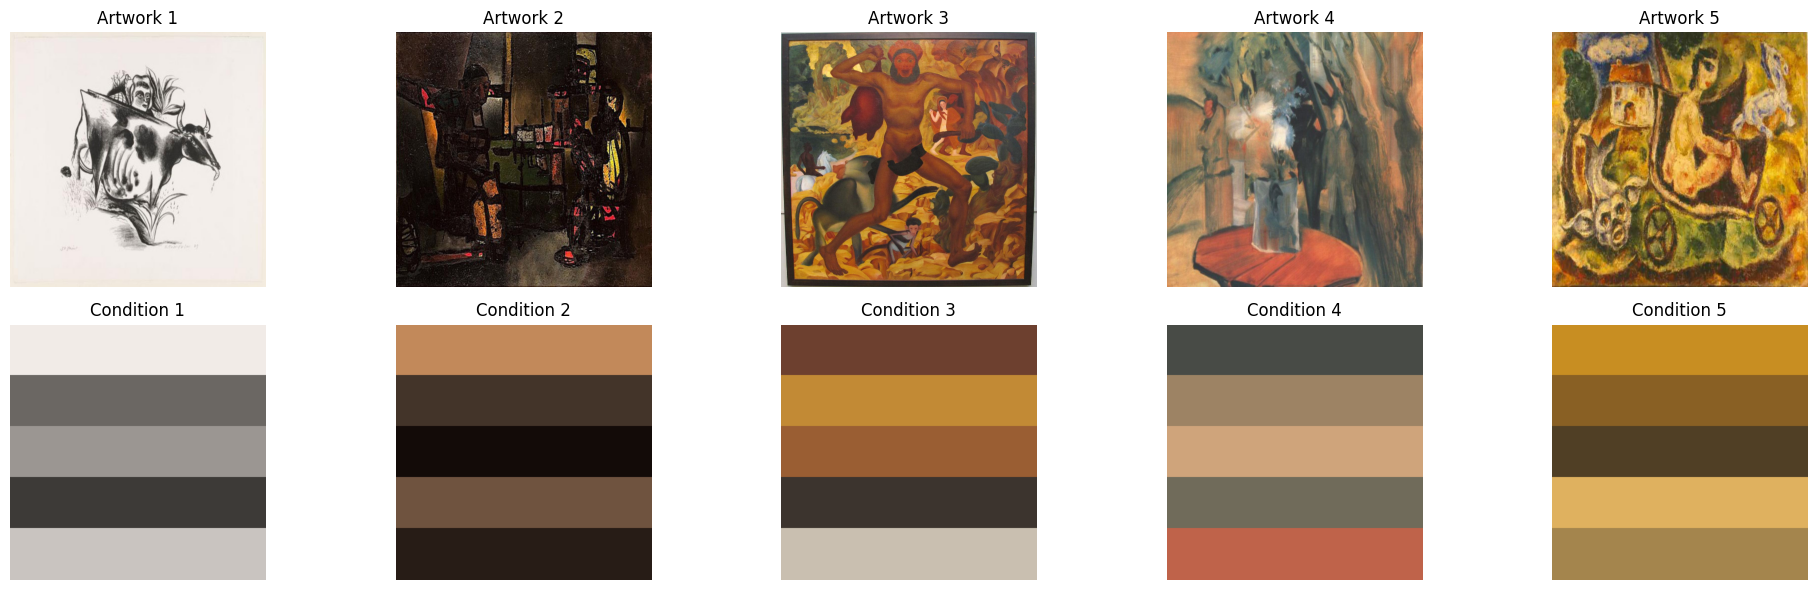


================ PROMPTS ================

[1] cow with female farmer out in the field

[2] a stained glass portrait of people looking at each other

[3] a naked man was shouting and holding something in his hands

[4] there is a bottle of flowers on the table in the hall

[5] the man just woke up from his bed and looked into the distance



In [8]:
# ==========================================================
# 8. VISUALIZE SAMPLES
# ==========================================================
import matplotlib.pyplot as plt
from PIL import Image

NUM_SAMPLES = 5
samples = metadata[:NUM_SAMPLES]

plt.figure(figsize=(4 * NUM_SAMPLES, 6))
for i, sample in enumerate(samples):
    # Artwork
    plt.subplot(2, NUM_SAMPLES, i + 1)
    plt.imshow(Image.open(os.path.join(OUT_ROOT, sample["image"])))
    plt.title(f"Artwork {i+1}")
    plt.axis("off")
    
    # Condition
    plt.subplot(2, NUM_SAMPLES, NUM_SAMPLES + i + 1)
    plt.imshow(Image.open(os.path.join(OUT_ROOT, sample["condition"])))
    plt.title(f"Condition {i+1}")
    plt.axis("off")

plt.tight_layout()
plt.show()

# Print prompts
print("\n================ PROMPTS ================\n")
for i, sample in enumerate(samples):
    with open(os.path.join(OUT_ROOT, sample["prompt"]), "r", encoding="utf-8") as f:
        prompt = f.read().strip()
    print(f"[{i+1}] {prompt}\n")